In [ ]:
# --- paths & imports ---
import os
import sys
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

ROOT = Path.cwd().parent  
sys.path.append(str(ROOT))

from src.utils import get_project_paths, set_seed, save_parquet
from src.data_prep import stratified_train_val_test_split
from src.features import add_basic_behavioral_features, add_simple_clv_proxy

set_seed(42)
paths = get_project_paths(ROOT)

sns.set(style="whitegrid")


In [ ]:
raw_path = paths.data_raw / "ecommerce_churn.xlsx"
df = pd.read_excel(raw_path,sheet_name="E Comm")

df.head()


,CustomerID,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,SatisfactionScore,MaritalStatus,NumberOfAddress,Complain,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount
0,50001,1,4.0,Mobile Phone,3,6.0,Debit Card,Female,3.0,3,Laptop & Accessory,2,Single,9,1,11.0,1.0,1.0,5.0,159.93
1,50002,1,NaN,Phone,1,8.0,UPI,Male,3.0,4,Mobile,3,Single,7,1,15.0,0.0,1.0,0.0,120.90
2,50003,1,NaN,Phone,1,30.0,Debit Card,Male,2.0,4,Mobile,3,Single,6,1,14.0,0.0,1.0,3.0,120.28
3,50004,1,0.0,Phone,3,15.0,Debit Card,Male,2.0,4,Laptop & Accessory,5,Single,8,0,23.0,0.0,1.0,3.0,134.07
4,50005,1,0.0,Phone,1,12.0,CC,Male,NaN,3,Mobile,5,Single,3,0,11.0,1.0,1.0,3.0,129.60


In [3]:
df.shape, df.columns
df.info()
df.describe(include="all").T


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5630 entries, 0 to 5629
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   CustomerID                   5630 non-null   int64  
 1   Churn                        5630 non-null   int64  
 2   Tenure                       5366 non-null   float64
 3   PreferredLoginDevice         5630 non-null   object 
 4   CityTier                     5630 non-null   int64  
 5   WarehouseToHome              5379 non-null   float64
 6   PreferredPaymentMode         5630 non-null   object 
 7   Gender                       5630 non-null   object 
 8   HourSpendOnApp               5375 non-null   float64
 9   NumberOfDeviceRegistered     5630 non-null   int64  
 10  PreferedOrderCat             5630 non-null   object 
 11  SatisfactionScore            5630 non-null   int64  
 12  MaritalStatus                5630 non-null   object 
 13  NumberOfAddress   

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
CustomerID,5630.0,NaN,NaN,NaN,52815.5,1625.385339,50001.0,51408.25,52815.5,54222.75,55630.0
Churn,5630.0,NaN,NaN,NaN,0.168384,0.37424,0.0,0.0,0.0,0.0,1.0
Tenure,5366.0,NaN,NaN,NaN,10.189899,8.557241,0.0,2.0,9.0,16.0,61.0
PreferredLoginDevice,5630,3,Mobile Phone,2765,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CityTier,5630.0,NaN,NaN,NaN,1.654707,0.915389,1.0,1.0,1.0,3.0,3.0
WarehouseToHome,5379.0,NaN,NaN,NaN,15.639896,8.531475,5.0,9.0,14.0,20.0,127.0
PreferredPaymentMode,5630,7,Debit Card,2314,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Gender,5630,2,Male,3384,NaN,NaN,NaN,NaN,NaN,NaN,NaN
HourSpendOnApp,5375.0,NaN,NaN,NaN,2.931535,0.721926,0.0,2.0,3.0,3.0,5.0
NumberOfDeviceRegistered,5630.0,NaN,NaN,NaN,3.688988,1.023999,1.0,3.0,4.0,4.0,6.0


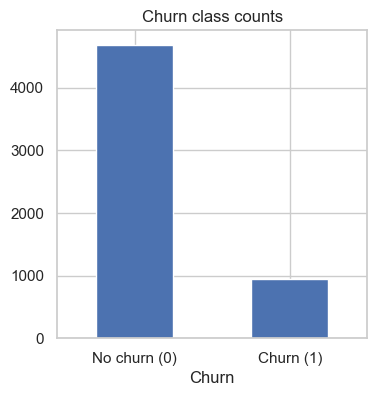

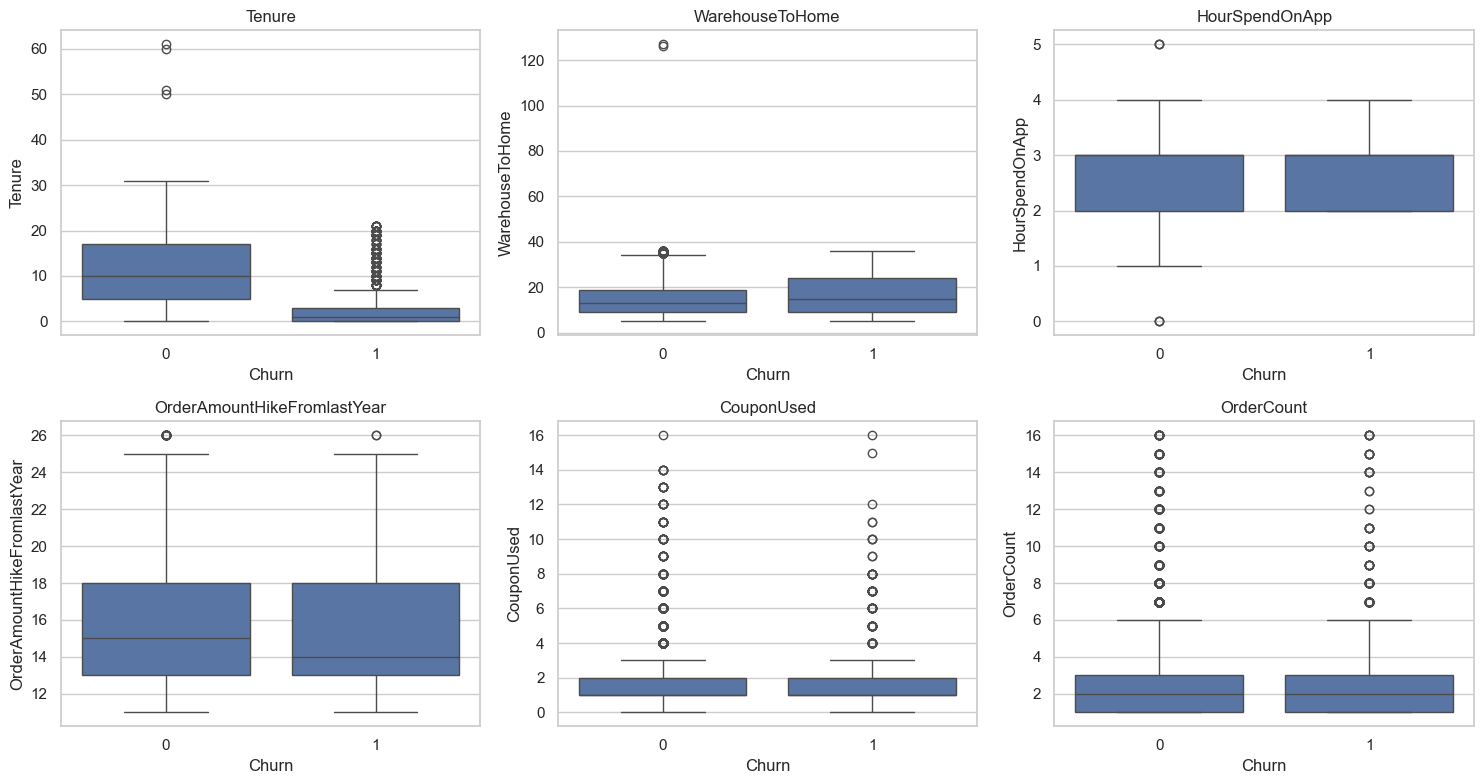

In [4]:
df["Churn"].value_counts(normalize=True).rename("share").to_frame()
plt.figure(figsize=(4,4))
df["Churn"].value_counts().plot(kind="bar")
plt.xticks([0,1], ["No churn (0)", "Churn (1)"], rotation=0)
plt.title("Churn class counts")
plt.show()
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel()

num_cols = ["Tenure", "WarehouseToHome", "HourSpendOnApp",
            "OrderAmountHikeFromlastYear", "CouponUsed", "OrderCount"]

for ax, col in zip(axes, num_cols):
    sns.boxplot(data=df, x="Churn", y=col, ax=ax)
    ax.set_title(col)

plt.tight_layout()
plt.show()


In [5]:
df.isna().sum().sort_values(ascending=False)


DaySinceLastOrder              307
OrderAmountHikeFromlastYear    265
Tenure                         264
OrderCount                     258
CouponUsed                     256
HourSpendOnApp                 255
WarehouseToHome                251
CustomerID                       0
MaritalStatus                    0
Complain                         0
NumberOfAddress                  0
PreferedOrderCat                 0
SatisfactionScore                0
Churn                            0
NumberOfDeviceRegistered         0
Gender                           0
PreferredPaymentMode             0
CityTier                         0
PreferredLoginDevice             0
CashbackAmount                   0
dtype: int64

In [6]:
target_col = "Churn"

numeric_features = [
    "Tenure",
    "CityTier",
    "WarehouseToHome",
    "HourSpendOnApp",
    "NumberOfDeviceRegistered",
    "SatisfactionScore",
    "NumberOfAddress",
    "Complain",
    "OrderAmountHikeFromlastYear",
    "CouponUsed",
    "OrderCount",
    "DaySinceLastOrder",
    "CashbackAmount",
]

categorical_features = [
    "PreferredLoginDevice",
    "PreferredPaymentMode",
    "Gender",
    "PreferedOrderCat",
    "MaritalStatus",
]


In [ ]:
df_beh = df.copy()

# Create a simple 'tenure_months' from Tenure for compatibility with src.features
df_beh["tenure_months"] = df_beh["Tenure"]

df_beh = add_basic_behavioral_features(
    df_beh,
    total_orders_col="OrderCount",
    total_spend_col="CashbackAmount",  
    last_order_date_col=None,  
)

df_beh = add_simple_clv_proxy(
    df_customers=df_beh,
    monetary_col="CashbackAmount",
    frequency_col="OrderCount",
    clv_col_name="clv_proxy",
)

df_beh[["OrderCount", "CashbackAmount", "avg_order_value", "clv_proxy"]].head()
df_beh["TenureBin"] = pd.cut(
    df_beh["Tenure"],
    bins=[0, 6, 12, 24, 60],
    labels=["0-6", "6-12", "12-24", "24+"],
    include_lowest=True,
)

df_beh["OrderCountBin"] = pd.cut(
    df_beh["OrderCount"],
    bins=[-0.1, 5, 10, 20, np.inf],
    labels=["0-5", "5-10", "10-20", "20+"],
    include_lowest=True,
)


/Users/arnavthakur/Documents/Data Science Projects/customer-analytics-churn-segmentation/src/features.py:79: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["avg_order_value"].fillna(0, inplace=True)


In [8]:
processed_path = paths.data_processed / "churn_ready.parquet"
save_parquet(df_beh, processed_path)
processed_path


PosixPath('/Users/arnavthakur/Documents/Data Science Projects/customer-analytics-churn-segmentation/data/processed/churn_ready.parquet')